In [2]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import networkx as nx
import folium

In [20]:
# Convert Node Coordinates from Illinois to Long/Lat
node_file = "ChicagoSketch_node.tntp"
nodes = []
reading_date = False
with open(node_file, "r") as file:
    for line in file:
        line = line.split(";")[0]
        print(line)
        if line.startswith("node"):
            reading_date = True
            continue
        if not reading_date or line.startswith("~") or line == "":
            continue
        parts = line.split()
        if len(parts) >= 3:
            node_id, x, y = int(parts[0]), float(parts[1]), float(parts[2])
            nodes.append((node_id, x, y))

# Convert to DataFrame
df_nodes = pd.DataFrame(nodes, columns=["Node", "X", "Y"])

# Convert Illinois State Plane (EPSG:3435) to Latitude/Longitude (EPSG:4326)
transformer = Transformer.from_crs("EPSG:26771", "EPSG:4326", always_xy=True)
df_nodes["Lon"], df_nodes["Lat"] = zip(*df_nodes.apply(lambda row: transformer.transform(row["X"], row["Y"]), axis=1))

print("Original Coordinates (Illinois State Plane):")
print(df_nodes[["X", "Y"]].head())

print("\nTransformed Coordinates (WGS84 - Lat/Lon):")
print(df_nodes[["Lat", "Lon"]].head())


# Check the first few converted coordinates
print(df_nodes.head())

# Convert to GeoDataFrame
gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry=gpd.points_from_xy(df_nodes["Lon"], df_nodes["Lat"]), crs="EPSG:4326")

gdf_nodes.to_csv("chicago_nodes_transformed.csv", index=False)

node	X	Y	
1	690309	1976022	
2	683649	1973025	
3	693306	1963368	
4	686313	1958373	
5	696636	1946718	
6	671328	1968030	
7	676323	1957041	
8	655677	1967031	
9	649350	1952712	
10	665667	1949049	
11	666333	1933398	
12	676323	1935396	
13	677988	1924407	
14	679653	1945719	
15	688977	1936062	
16	692307	1925739	
17	700965	1935396	
18	702963	1927404	
19	704295	1919412	
20	678654	1912752	
21	691641	1917747	
22	705294	1911087	
23	693972	1906425	
24	679653	1904760	
25	664002	1893771	
26	680652	1891107	
27	694971	1889775	
28	707625	1900098	
29	710955	1884447	
30	680319	1878120	
31	696303	1873791	
32	689643	1861803	
33	705627	1851147	
34	705960	1865133	
35	722610	1876122	
36	723609	1856142	
37	625374	1965033	
38	550449	2013984	
39	590076	2021310	
40	573426	2021310	
41	590076	2005326	
42	573759	2005326	
43	622377	2020977	
44	606060	2021310	
45	622377	2005326	
46	605727	2004660	
47	654345	2021310	
48	638361	2021310	
49	654012	2005326	
50	638361	2005326	
51	667998	2020311	
52	683982	2001330	
53	670329	2

[(1, 547, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (2, 548, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (3, 549, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (4, 550, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (5, 551, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (6, 552, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (7, 553, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (8, 554, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (9, 555, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (10, 556, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (11, 557, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (12, 558, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (13, 559, {'capacity': 49500.0, 'length': 0.86267, 'free_flow_time': 0.0}), (14, 560, {'capacity

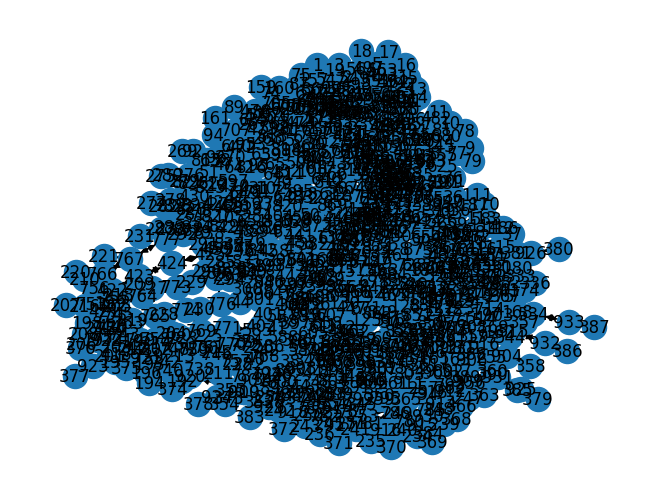

In [4]:
# Load the Road Network (ChicagoSketch_net.tntp)
network_file = "ChicagoSketch_net.tntp"
edges = []
reading_data = False

with open(network_file, "r") as file:
    for line in file:
        if line.startswith("<END OF METADATA>"):
            reading_data = True
            continue
        if not reading_data or line.startswith("~") or line.startswith("<") or line == "":
            continue
        line = line.split(";")[0]
        parts = line.split()
        if len(parts) >= 6:
            init_node, term_node = int(parts[0]), int(parts[1])
            capacity, length, free_flow_time = map(float, parts[2:5])
            edges.append((init_node, term_node, {"capacity": capacity, "length": length, "free_flow_time": free_flow_time}))
G = nx.DiGraph()
G.add_edges_from(edges)
nx.draw(G, with_labels=True)

print(edges)


In [18]:
# Create Chicago map
# m = folium.Map(location=[41.8781, -87.6298], zoom_start=11)
center_lat = df_nodes["Lat"].mean()
center_lon = df_nodes["Lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)
# m = folium.Map(location=[41.8781, -87.6298], zoom_start=12)


print(center_lat, center_lon)
# Add roads to map
for edge in edges:
    start, end, attr = edge
    lon1, lat1 = df_nodes.loc[df_nodes["Node"] == start, ["Lon", "Lat"]].values[0]
    lon2, lat2 = df_nodes.loc[df_nodes["Node"] == end, ["Lon", "Lat"]].values[0]

    # Color roads based on free-flow time
    color = "green" if attr["free_flow_time"] < 5 else "orange" if attr["free_flow_time"] < 10 else "red"

    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color=color, weight=3, opacity=0.7).add_to(m)

# Display map
m.save("chicago_map.html")

m


41.91232895468069 -87.95152438099583


In [24]:
# Mean Degree
# 2E / N 
N = 933
E = 2950
mean_degree = 2 * E / N
mean_degree

6.323687031082529

Mean Degree of approximately 6

This is a directed network. Each road segment counts as two directed edges if traffic can flow both ways
Road networks in urban areas often have degrees around 4–8 because intersections frequently connect multiple roads.
A mean degree around 6 indicates that intersections are generally connected to around 3 roads (considering incoming and outgoing separately).


We can check for a giant component

if most nodes belong to a giant component, then the transit network is largely reachable as a whole
There are minimal isolated sub-networks – most routes interlink, which is expected in a comprehensive city transit system. This ensures that, in principle, a rider can get from almost any stop to another

In [ ]:
# Betweenness Centrality